In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

last_date_tuple = tuple(map(int, last_date.split("-")))

last_date_tuple

(2017, 8, 23)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(last_date_tuple[0], last_date_tuple[1], last_date_tuple[2]) - dt.timedelta(days = 365)

year_ago = year_ago.strftime("%Y-%m-%d")

In [11]:
# Perform a query to retrieve the data and precipitation scores
date_prcp_query = session.query(Measurement.date, Measurement.prcp)\
.filter(Measurement.date >= year_ago)

In [12]:
# Create connection to save query into a dataframe
conn = engine.connect()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.read_sql(date_prcp_query.statement, conn)

date_prcp_df.head(100)

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
95,2016-11-26,0.05
96,2016-11-27,0.00
97,2016-11-28,0.01
98,2016-11-29,0.00


In [14]:
# Sort the dataframe by date
date_prcp_df = date_prcp_df.sort_values(by = "date")

date_prcp_df

,date,prcp
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


<AxesSubplot:title={'center':'Precipitation in Honolulu'}, xlabel='Date', ylabel='Inches'>

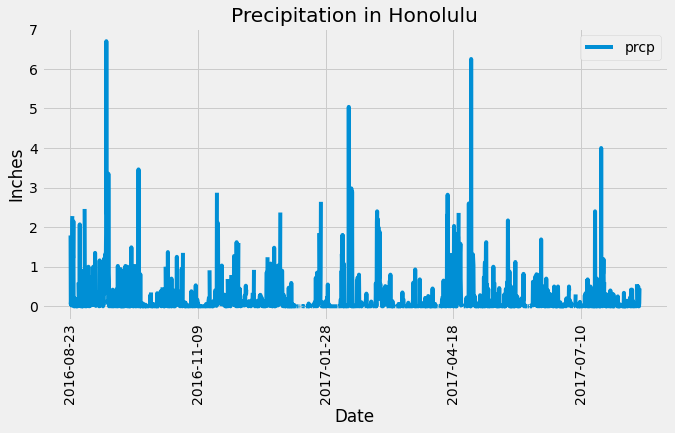

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
date_prcp_df.plot(x = "date", y = "prcp", xlabel = "Date", ylabel = "Inches"\
                  , title = "Precipitation in Honolulu", rot = 90, figsize = (10,5))

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_summary_statistics = date_prcp_df["prcp"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])

prcp_summary_statistics

max       6.700000
min       0.000000
mean      0.177279
median    0.020000
var       0.212696
std       0.461190
sem       0.010259
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
stations_count = session.query(Measurement.station).distinct(Measurement.station).count()

print(f"There are a total of {stations_count} stations in the database.")

There are a total of 9 stations in the database.


C:\Users\liefh\AppData\Local\Temp\ipykernel_23264\475218189.py:2: SADeprecationWarning: DISTINCT ON is currently supported only by the PostgreSQL dialect.  Use of DISTINCT ON for other backends is currently silently ignored, however this usage is deprecated, and will raise CompileError in a future release for all backends that do not support this syntax.
  stations_count = session.query(Measurement.station).distinct(Measurement.station).count()


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
total_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()

most_active_station = total_stations[0][0]

total_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_max_avg_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
.filter(Measurement.station == most_active_station).all()

min_max_avg_temps

[(54.0, 85.0, 71.66378066378067)]

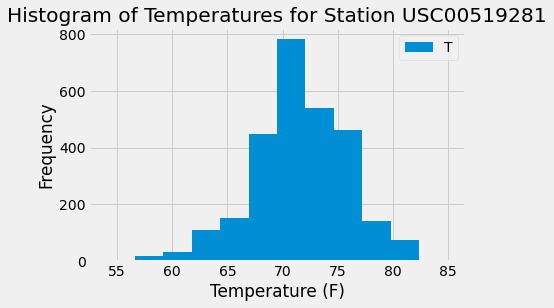

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_temps = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).all()

temps = []

for temp in most_active_station_temps:
    temps.append(temp[0])
    
len(temps)

plt.hist(x = temps, bins = 12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title(f"Histogram of Temperatures for Station {most_active_station}")
plt.legend("Temperature")
plt.show()

# Close session

In [21]:
# Close Session
session.close()